In [7]:
import math
import ast
import statistics
import numpy as np
import os
import csv
import json
from collections import defaultdict
import scipy.stats as stats
import matplotlib.pyplot as plt
import random as nd
import pickle as pkl
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
%pylab inline
%load_ext autoreload
%autoreload 2

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Main data parsing functions

In [8]:
def save_plot_data(obj, name, path):
    with open(path+name+'.pkl', 'wb') as f:
        pkl.dump(obj, f, pkl.HIGHEST_PROTOCOL)

def load_plot_data(name, path):
    with open(path+name+'.pkl', 'rb') as f:
        return pkl.load(f)

def load_json_data(inputfile):
    summ_data = []
    
    with open(inputfile) as json_file:
        summ_data = json.load(json_file)
        print('agent_ID: ' + summ_data['agent_ID'])
        #print('agent_type: ' + summ_data['agent_type'])
        #print('total_episodes: ' + str(summ_data['total_episodes']))
        #print('total_reward: ' + str(summ_data['total_reward']))
        #print('avg_rec_err: ' + str(summ_data['avg_rec_err']))
        #print('CL_ratio: ' + str(summ_data['CL_ratio']))
        #print('STM_length: ' + str(summ_data['STM_length']))
        #print('rec_thres: ' + str(summ_data['rec_thres']))
        #print('mean_step_rew: ' + str(summ_data['mean_step_rew']))
        #print('mean_step_log: ' + data['mean_step_log'])
        #print('wins_reactive: ' + str(summ_data['wins_reactive']))
        #print('wins_contextual: ' + str(summ_data['wins_contextual']))
        #print('auto_reliable: ' + str(summ_data['auto_reliable']))

    return summ_data

def load_csv_data(inputfile):

    # initializing the titles and rows list 
    fields = [] 
    data = [] 

    # reading csv file 
    with open(inputfile, 'r') as csvfile: 
        # creating a csv reader object 
        csvreader = csv.reader(csvfile) 

        # extracting field names through first row  
        fields = next(csvreader) 
        
        # printing the field names 
        #print('Field names are: ' + ', '.join(field for field in fields)) 
        
        # extracting each data row one by one 
        for row in csvreader: 
            if len(row) > 0:
                data.append(row) 
               
        #print('Data length: ', len(data))

        # get total number of rows 
        print("Total no. of rows: %d"%(csvreader.line_num)) 
    
    print("Data length: ", len(data))  

    return data

def get_reward_ep(data):
    reward_ep = []
    for d in data:
        reward_ep.append(d[0])
    return reward_ep

def get_rec_error_mean(data):
    rec_error_mean = []
    for d in data:
        rec_error_mean.append(d[1])
    return rec_error_mean

def get_reward_logs(data):
    reward_logs = []
    for d in data:
        reward_logs.append(d[2])
    return reward_logs

def get_rec_error_logs(data):
    rec_error_logs = []
    for d in data:
        rec_error_logs.append(d[3])
    return rec_error_logs

def get_agent_speed_logs(data):
    agent_speed_logs = []
    for d in data:
        agent_speed_logs.append(d[4])
    return agent_speed_logs

def get_agent_pos_logs(data):
    agent_pos_logs = []
    for d in data:
        agent_pos_logs.append(d[5])
    return agent_pos_logs

def get_active_layer_logs(data, model):
    active_layer_logs = []
    for d in data:
        active_layer_logs.append(d[6])
        #active_layer_logs.append(d[6]) if model != 'MFEC' else active_layer_logs.append(d[5])
    return active_layer_logs

def get_entropy_logs(data, model):
    entropy_logs = []
    for d in data:
        entropy_logs.append(d[6])
        #if model != 'MFEC': entropy_logs.append(d[7]) 
    return entropy_logs

def get_action_sel_logs(data, model):
    action_sel_logs = []
    for d in data:
        action_sel_logs.append(d[8])
        #action_sel_logs.append(d[8]) if model != 'MFEC' else action_sel_logs.append(d[6])
    return action_sel_logs

def get_reward_ts(reward_ep, ltm_length):
    #ltm = int(ltm_length[3:])
    ltm = ltm_length

    abs_tru_reward_ts = []
    abs_rnd_reward_ts = []
    acc_tru_reward = 0
    acc_tru_reward_ts = []
    acc_rnd_reward = 0
    acc_rnd_reward_ts = []
    count_ltm = 0
    index_eps = 0
    ltm_complete = 0
    
    for episode in reward_ep:
        #print(episode)
        r = float(episode)
        
        #print(r)
        if r > 0:
            #print(r)
            abs_tru_reward_ts.append(r)
            abs_rnd_reward_ts.append(3)
            acc_tru_reward += r
            acc_rnd_reward += 3
            count_ltm += 1
        else:
            abs_tru_reward_ts.append(0)
            abs_rnd_reward_ts.append(0)
            acc_tru_reward += 0
            acc_rnd_reward += 0
            
        if count_ltm == ltm: 
            ltm_complete = index_eps
            ltm = -1
            
        acc_tru_reward_ts.append(acc_tru_reward)
        acc_rnd_reward_ts.append(acc_rnd_reward)
        index_eps += 1
        
    return abs_tru_reward_ts, abs_rnd_reward_ts, acc_tru_reward_ts, acc_rnd_reward_ts, ltm_complete


def get_steps_ts(reward_ep, steps_data, cl=4):
    #default episode total actions: 
    # CL4 - 251, CL2 - 501, # CL1 - 1001
    #print(cl[1])
    #default_steps = round(1000 / int(cl[1:]))
    default_steps = round(1000 / cl)
    steps_index = 0
    ep_steps_ts = []
    acc_steps = 0
    acc_steps_ts = []
    steps = steps_data
    #steps = json_data['mean_step_log']
    #for episode in reward_ep:
    for episode in reward_ep:
        #print(episode)
        r = float(episode)
        #print(r)
        if r > 0:
            ep_steps_ts.append(int(steps[steps_index]))
            acc_steps += int(steps[steps_index])
            steps_index += 1 
        else:
            ep_steps_ts.append(default_steps)
            acc_steps += default_steps
            
        acc_steps_ts.append(acc_steps)    
                    
    return ep_steps_ts, acc_steps_ts

def get_condition_data(cl, stm):
    data = []
    for r,d,f in os.walk(base_path):
        for files in f:
            if files.startswith('c'+str(cl)+'-stm'+str(stm)) and files.endswith('.csv'):
                #ts = []
                inputfile = r + files
                print("r: ", r)
                data = load_data(inputfile)
    return data


def get_layer_reliance_ep(layer_logs):
    reactive_reliance = []
    contextual_reliance = []
    episode_dominance = []
    episode_last = []
    for ep in layer_logs:
        contextual = 0
        reactive = 0
        for d in ep:
            if d == 'C': contextual += 1
            if d == 'R': reactive += 1
        if contextual >= reactive: episode_dominance.append('C')
        else: episode_dominance.append('R')
        if (reactive+contextual) > 0:
            rel_reactive = reactive / (reactive+contextual)
            rel_contextual = contextual / (reactive+contextual)
        else:
            rel_reactive = 0
            rel_contextual = 0
        reactive_reliance.append(rel_reactive)
        contextual_reliance.append(rel_contextual)
        episode_last.append(ep[-3])
    return episode_dominance, episode_last, reactive_reliance, contextual_reliance


def get_layer_reward_ts_last(reward_ep, steps_data, ep_last):
    count_reactive = 0
    abs_reward_reactive = []
    abs_reward_contextual = []
    acc_contextual_reward = 0
    acc_reactive_reward = 0
    acc_reward_reactive = []
    acc_reward_contextual = []
    #count_steps = 0
    steps_reactive = []
    steps_contextual = []
    steps = steps_data
    #steps = json_data['mean_step_log']
    #for episode in reward_ep:
    for i in range (len(reward_ep)):
        #print(episode)
        r = float(reward_ep[i])
        #print(r)
        if r >= 1.:
            #if count_reactive > 4:
            if ep_last[i] == 'R':
                acc_reactive_reward += r
                abs_reward_reactive.append(r)
                acc_reward_reactive.append(acc_reactive_reward)
                steps_reactive.append(steps[count_reactive])
                
                abs_reward_contextual.append(0)
                acc_reward_contextual.append(acc_contextual_reward)
            else:
                acc_contextual_reward += r
                abs_reward_contextual.append(r)
                acc_reward_contextual.append(acc_contextual_reward)
                steps_contextual.append(steps[count_reactive])  
                
                abs_reward_reactive.append(0)
                acc_reward_reactive.append(acc_reactive_reward)
                    
            count_reactive += 1                
            #count_steps += 1  
        
    return abs_reward_reactive, acc_reward_reactive, abs_reward_contextual, acc_reward_contextual, steps_reactive, steps_contextual

def get_mean_entropy(data):
    mean_entropy_ep = []
    for d in data:
        #a = np.fromstring(d[1:-1], dtype=float, sep=',')
        float_array = ast.literal_eval(d)
        mean_entropy = np.mean(float_array)
        mean_entropy_ep.append(mean_entropy)
    return mean_entropy_ep

def get_encoder_reliability_ts(rec_error_logs, rec_thresh=0):
    data = rec_error_logs
    reconstruct_thres = rec_thresh
    encoder_reliability_ts = []

    for ep in data:
        a = np.fromstring(ep[1:-1], dtype=float, sep=',')
        #print(len(a))
        count_reliable = 0
        count_unreliable = 0
        encoder_reliability = 0
        for rec_error_ts in a:
            if rec_error_ts < reconstruct_thres: 
                #print ('Reconstruction Error RELIABLE')
                count_reliable +=1  
            else:
                #print ('Reconstruction Error UNRELIABLE') 
                count_unreliable +=1
        encoder_reliability = (count_reliable / (count_reliable+count_unreliable)) * 100
        encoder_reliability_ts.append(encoder_reliability)
    return encoder_reliability_ts

In [9]:
def get_condition_dac(filepath, model, ltm_length=500):
    
    agent = "dac"
    indx = 0
    jsn_data = 0
    agent_ID = ""
    
    rec_threshold=0.01

    #big_list = []
    big_json = []
    big_steps = []
    big_autoencoder_trust_rel, big_autoencoder_trust_ts = [], []
    big_reward_ep = []
    big_abs_tru_reward, big_abs_rnd_reward, big_acc_tru_reward, big_acc_rnd_reward = [], [], [], []
    big_layer_data = []
    big_ep_dominance, big_ep_last, big_reactive_rel, big_contextual_rel =  [], [], [], []
    big_abs_rew_reactive, big_acc_rew_reactive, big_abs_rew_contextual, big_acc_rew_contextual, big_steps_reactive, big_steps_contextual = [], [], [], [], [], []
    big_rec_error_logs = []
    big_wins_reactive, big_wins_contextual = [], []
    #big_autoencoder_trust_ts = []  
    big_entropy_data, big_mean_entropy = [], []
    big_real_steps, big_acc_steps = [], []
    big_ltm_complete = []
    big_pos = []

    print(filepath+'{0}/'.format(model))
    for r,d,f in os.walk(filepath+'{0}/'.format(model)):
        #print("oink! 0")
        for files in f:
            if files.endswith('.json'):
                filename = r+'/'+files
                jsn_data = load_json_data(filename)
                agent_ID = jsn_data['agent_ID']
                agent_type = jsn_data['agent_type']
                big_json.append(jsn_data)
                big_autoencoder_trust_rel.append(jsn_data['auto_reliable'])
                mean_steps_log = jsn_data['mean_step_log']
                big_steps.append(mean_steps_log)
                big_wins_reactive.append(jsn_data['wins_reactive'])
                big_wins_contextual.append(jsn_data['wins_contextual'])
                #print("oink! 1: ", agent_ID)
                for r,d,f in os.walk(filepath+'{0}/'.format(model)):
                    #print("oink! 2a")
                    for files in f:
                        if files.startswith(agent_ID) and files.endswith('.csv'):
                            #print("oink! 2b: ", agent_ID)
                            filename = r+'/'+files
                            #print("oink! 2c: ", filename)
                            csv_data = load_csv_data(filename)
                            reward_ep = get_reward_ep(csv_data)
                            big_reward_ep.append(reward_ep)
                            abs_tru_reward, abs_rnd_reward, acc_tru_reward, acc_rnd_reward, ltm_full = get_reward_ts(reward_ep, ltm_length)
                            big_abs_tru_reward.append(abs_tru_reward)
                            big_abs_rnd_reward.append(abs_rnd_reward)
                            big_acc_tru_reward.append(acc_tru_reward)
                            big_acc_rnd_reward.append(acc_rnd_reward)
                            big_ltm_complete.append(ltm_full)
                            if agent_type != "reactive": 
                                rec_error_logs = get_rec_error_logs(csv_data)
                                big_rec_error_logs.append(rec_error_logs)
                                #autoencoder_trust_ts = get_encoder_reliability_ts(rec_error_logs, rec_threshold)
                                #big_autoencoder_trust_ts.apppend(autoencoder_trust_ts)
                                entropy_data = get_entropy_logs(csv_data, agent_type)
                                mean_entropy = get_mean_entropy(entropy_data)
                                big_entropy_data.append(entropy_data)
                                big_mean_entropy.append(mean_entropy)
                            #if model == "dac-pos" or model == "dac-nobias-pos":
                                #agent_pos_logs = get_agent_pos_logs(csv_data)
                                #big_pos.append(agent_pos_logs)
                            indx += 1
                      
    big_list = {}

    #big_list['agent_ID'] = ID
    big_list['abs_tru_reward'] = big_abs_tru_reward
    big_list['acc_tru_reward'] = big_acc_tru_reward  #this
    big_list['reward_steps_ts'] = big_steps
    big_list['real_steps_ts'] = big_real_steps  #this
    big_list['acc_steps_ts'] = big_acc_steps  #this
    big_list['mean_entropy'] = big_mean_entropy #this
    big_list['LTM_full'] = big_ltm_complete 
                
    return big_list

# Parse single condition

In [10]:
#file_path = 'E:/SEC_paper_data/exp1/'

file_path = '../data/exp1_2tmaze/'
plot_path = '../results/'

In [13]:
model = 'DQN'
data = get_condition_dac(file_path, model)

../data/exp1_2tmaze/DQN/


In [14]:
len(data['abs_tru_reward'][0])
np.sum(data['abs_tru_reward'][2])

IndexError: list index out of range

In [15]:
len(data['mean_entropy'])

0

In [48]:
data['mean_entropy'][0][-1]

0.02827722923552341

In [49]:
for i in range (len(data['mean_entropy'])):
    print(data['mean_entropy'][i][-1])

0.02827722923552341
0.960131641977782
0.02556509038768208
0.09482911320845677
0.05504785069420992
0.5179438592946828
0.02885187685892991
0.03722238824710018
0.00812123594462006
0.0506988281004686
0.033788576810041444
0.04112486802231625
0.0650349492711058


In [50]:
len(data)

7

In [51]:
save_plot_data(data, model, file_path)

In [24]:
data.keys()

dict_keys(['abs_tru_reward', 'acc_tru_reward', 'reward_steps_ts', 'real_steps_ts', 'acc_steps_ts', 'mean_entropy', 'LTM_full'])

# Parse all conditions

In [15]:
#file_path = 'E:/SEC_paper_data/exp1_detour_GOOD/'
#file_path = '../data/exp1_detour_GOOD/'
file_path = '../data/exp2_adri/'
plot_path = '../data/exp2_adri/'
task = 'permanence'
#models = ['noGi_500', 'NSEC_500', 'NSEC_1000', 'SEC_500', 'SEC_1000', 'MFEC_VAE_25K', 'MFEC_RP_25K', 'MFEC_VAE_100K', 'MFEC_RP_100K', 'ERLAM_5k', 'ERLAM_25k', 'DQN_5k', 'DQN_25k']
models = ['MFEC_ae100_'+task, 'MFEC_sparse100_'+task]
#models = ['MFEC_ae100_'+task, 'MFEC_sparse100_'+task, 'SEC_ae100_'+task, 'SEC_sparse100_'+task]
#models = ['MFEC_sparse100_'+task]
#models = ['NSEC_500']
data = {}

In [16]:
for model in models:
    data[model] = get_condition_dac(file_path, model)
    save_plot_data(data[model], model, file_path)

../data/exp2_adri/MFEC_ae100_permanence/
agent_ID: MFEC_permanence_pytorch-AE_pl100-kn50-ltm100000_agent-0jp0hq_
Total no. of rows: 10002
Data length:  5000
agent_ID: MFEC_permanence_pytorch-AE_pl100-kn50-ltm100000_agent-0rvxww_
Total no. of rows: 10002
Data length:  5000
agent_ID: MFEC_permanence_pytorch-AE_pl100-kn50-ltm100000_agent-3ggl42_
Total no. of rows: 10002
Data length:  5000
agent_ID: MFEC_permanence_pytorch-AE_pl100-kn50-ltm100000_agent-5n8yl0_
Total no. of rows: 10002
Data length:  5000
agent_ID: MFEC_permanence_pytorch-AE_pl100-kn50-ltm100000_agent-8hvw47_
Total no. of rows: 10002
Data length:  5000
agent_ID: MFEC_permanence_pytorch-AE_pl100-kn50-ltm100000_agent-ccb8ft_
Total no. of rows: 10002
Data length:  5000
agent_ID: MFEC_permanence_pytorch-AE_pl100-kn50-ltm100000_agent-ehd9g9_
Total no. of rows: 10002
Data length:  5000
agent_ID: MFEC_permanence_pytorch-AE_pl100-kn50-ltm100000_agent-oj6ilm_
Total no. of rows: 10002
Data length:  5000
agent_ID: MFEC_permanence_pytor

In [22]:
len(data)

4

In [55]:
data = load_plot_data('MFEC-ae', file_path)

In [56]:
data.keys()

dict_keys(['abs_tru_reward', 'acc_tru_reward', 'reward_steps_ts', 'real_steps_ts', 'acc_steps_ts', 'mean_entropy', 'LTM_full', 'reactive_relact', 'contextual_relact', 'reactive_wins', 'contextual_wins', 'abs_rew_reactive', 'abs_rew_contextual', 'acc_rew_reactive', 'acc_rew_contextual', 'steps_reactive', 'steps_contextual'])

In [ ]:
data['mean_entropy'][0]

# Save parsed data for future use

In [4]:
#data = load_plot_data('DQN', file_path)
#file_path = 'E:/SEC_paper_data/exp1/'
#file_path = '../data/exp1_cylinder/'
#plot_path = '../data/exp1_cylinder/'
file_path = '../data/exp2_adri/'
plot_path = '../data/exp2_adri/'

In [17]:
#models = ['noGi_500', 'NSEC_500', 'NSEC_1000', 'SEC_500', 'SEC_1000', 'MFEC_VAE_25K', 'MFEC_RP_25K', 'MFEC_VAE_100K', 'MFEC_RP_100K']
#models = ['noGi_500', 'NSEC_500', 'NSEC_1000', 'SEC_500', 'SEC_1000', 'MFEC_VAE_25K', 'MFEC_RP_25K', 'MFEC_VAE_100K', 'MFEC_RP_100K', 'ERLAM_5k', 'ERLAM_25k', 'DQN_5k', 'DQN_25k']
#models = ['noGi', 'MFEC-ae', 'MFEC-rp', 'SEC', 'NSEC', 'DQN', 'ERLAM']
#models = ['noGi_500', 'NSEC_500', 'SEC_500', 'SEC_1000', 'MFEC_VAE_25K', 'MFEC_RP_25K', 'MFEC_VAE_100K', 'MFEC_RP_100K', 'ERLAM_5k', 'ERLAM_25k', 'DQN_5k', 'DQN_25k']
#models = ['DQN_ae100_cylinder', 'DQN_sparse100_cylinder', 'DQN_ae1k_cylinder', 'DQN_sparse1k_cylinder', 'MFEC_ae100_cylinder', 'MFEC_sparse100_cylinder', 'SEC_ae100_cylinder', 'SEC_sparse100_cylinder']
#models = ['DQN_ae100_cylinder', 'DQN_sparse100_cylinder', 'MFEC_ae100_cylinder', 'MFEC_sparse100_cylinder', 'SEC_ae100_cylinder', 'SEC_sparse100_cylinder']
task = 'permanence'
#models = ['MFEC_ae100_'+task, 'MFEC_sparse100_'+task]
#models = ['noGi_500', 'NSEC_500', 'NSEC_1000', 'SEC_500', 'SEC_1000', 'MFEC_VAE_25K', 'MFEC_RP_25K', 'MFEC_VAE_100K', 'MFEC_RP_100K', 'ERLAM_5k', 'ERLAM_25k', 'DQN_5k', 'DQN_25k']
models = ['DQN_ae100_'+task, 'DQN_sparse100_'+task, 'MFEC_ae100_'+task, 'MFEC_sparse100_'+task, 'SEC_ae100_'+task, 'SEC_sparse100_'+task]

data = {}

for model in models:
    model_data = load_plot_data(model, file_path)
    data[model] = model_data
    

In [54]:
task = 'tmaze'
#models = ['MFEC_ae100_'+task, 'MFEC_sparse100_'+task]
#models = ['noGi_500', 'NSEC_500', 'NSEC_1000', 'SEC_500', 'SEC_1000', 'MFEC_VAE_25K', 'MFEC_RP_25K', 'MFEC_VAE_100K', 'MFEC_RP_100K', 'ERLAM_5k', 'ERLAM_25k', 'DQN_5k', 'DQN_25k']
models = ['DQN_ae1k_'+task, 'DQN_sparse1k_'+task]

data = {}

for model in models:
    model_data = load_plot_data(model, file_path)
    data[model] = model_data
    

In [55]:
data.keys()

dict_keys(['DQN_ae1k_tmaze', 'DQN_sparse1k_tmaze'])

In [56]:
save_plot_data(data, 'data_1k_'+task, file_path)

In [57]:
data = load_plot_data('data_1k_'+task, file_path)

In [58]:
data.keys()

dict_keys(['DQN_ae1k_tmaze', 'DQN_sparse1k_tmaze'])

# Rewards - single

In [59]:
# Variables a computar para reward plot
window_width = 20
data_trureward = data['SEC_ae100_permanence']['abs_tru_reward']
data_trureward = np.asarray(data_trureward, dtype=np.float32)

mean = np.mean(data_trureward, axis=0)
yerr = np.std(data_trureward, axis=0) / math.sqrt(len(data_trureward))

data_trureward_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
data_trureward_mavecr = (data_trureward_cumsum[window_width:] - data_trureward_cumsum[:-window_width]) / window_width

data_trureward_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
data_trureward_mavecr_std = (data_trureward_cumsum_std[window_width:] - data_trureward_cumsum_std[:-window_width]) / window_width

min_val = data_trureward_mavecr - data_trureward_mavecr_std
max_val = data_trureward_mavecr + data_trureward_mavecr_std
length = data_trureward_mavecr_std.shape[0]

KeyError: 'SEC_ae100_permanence'

NameError: name 'length' is not defined

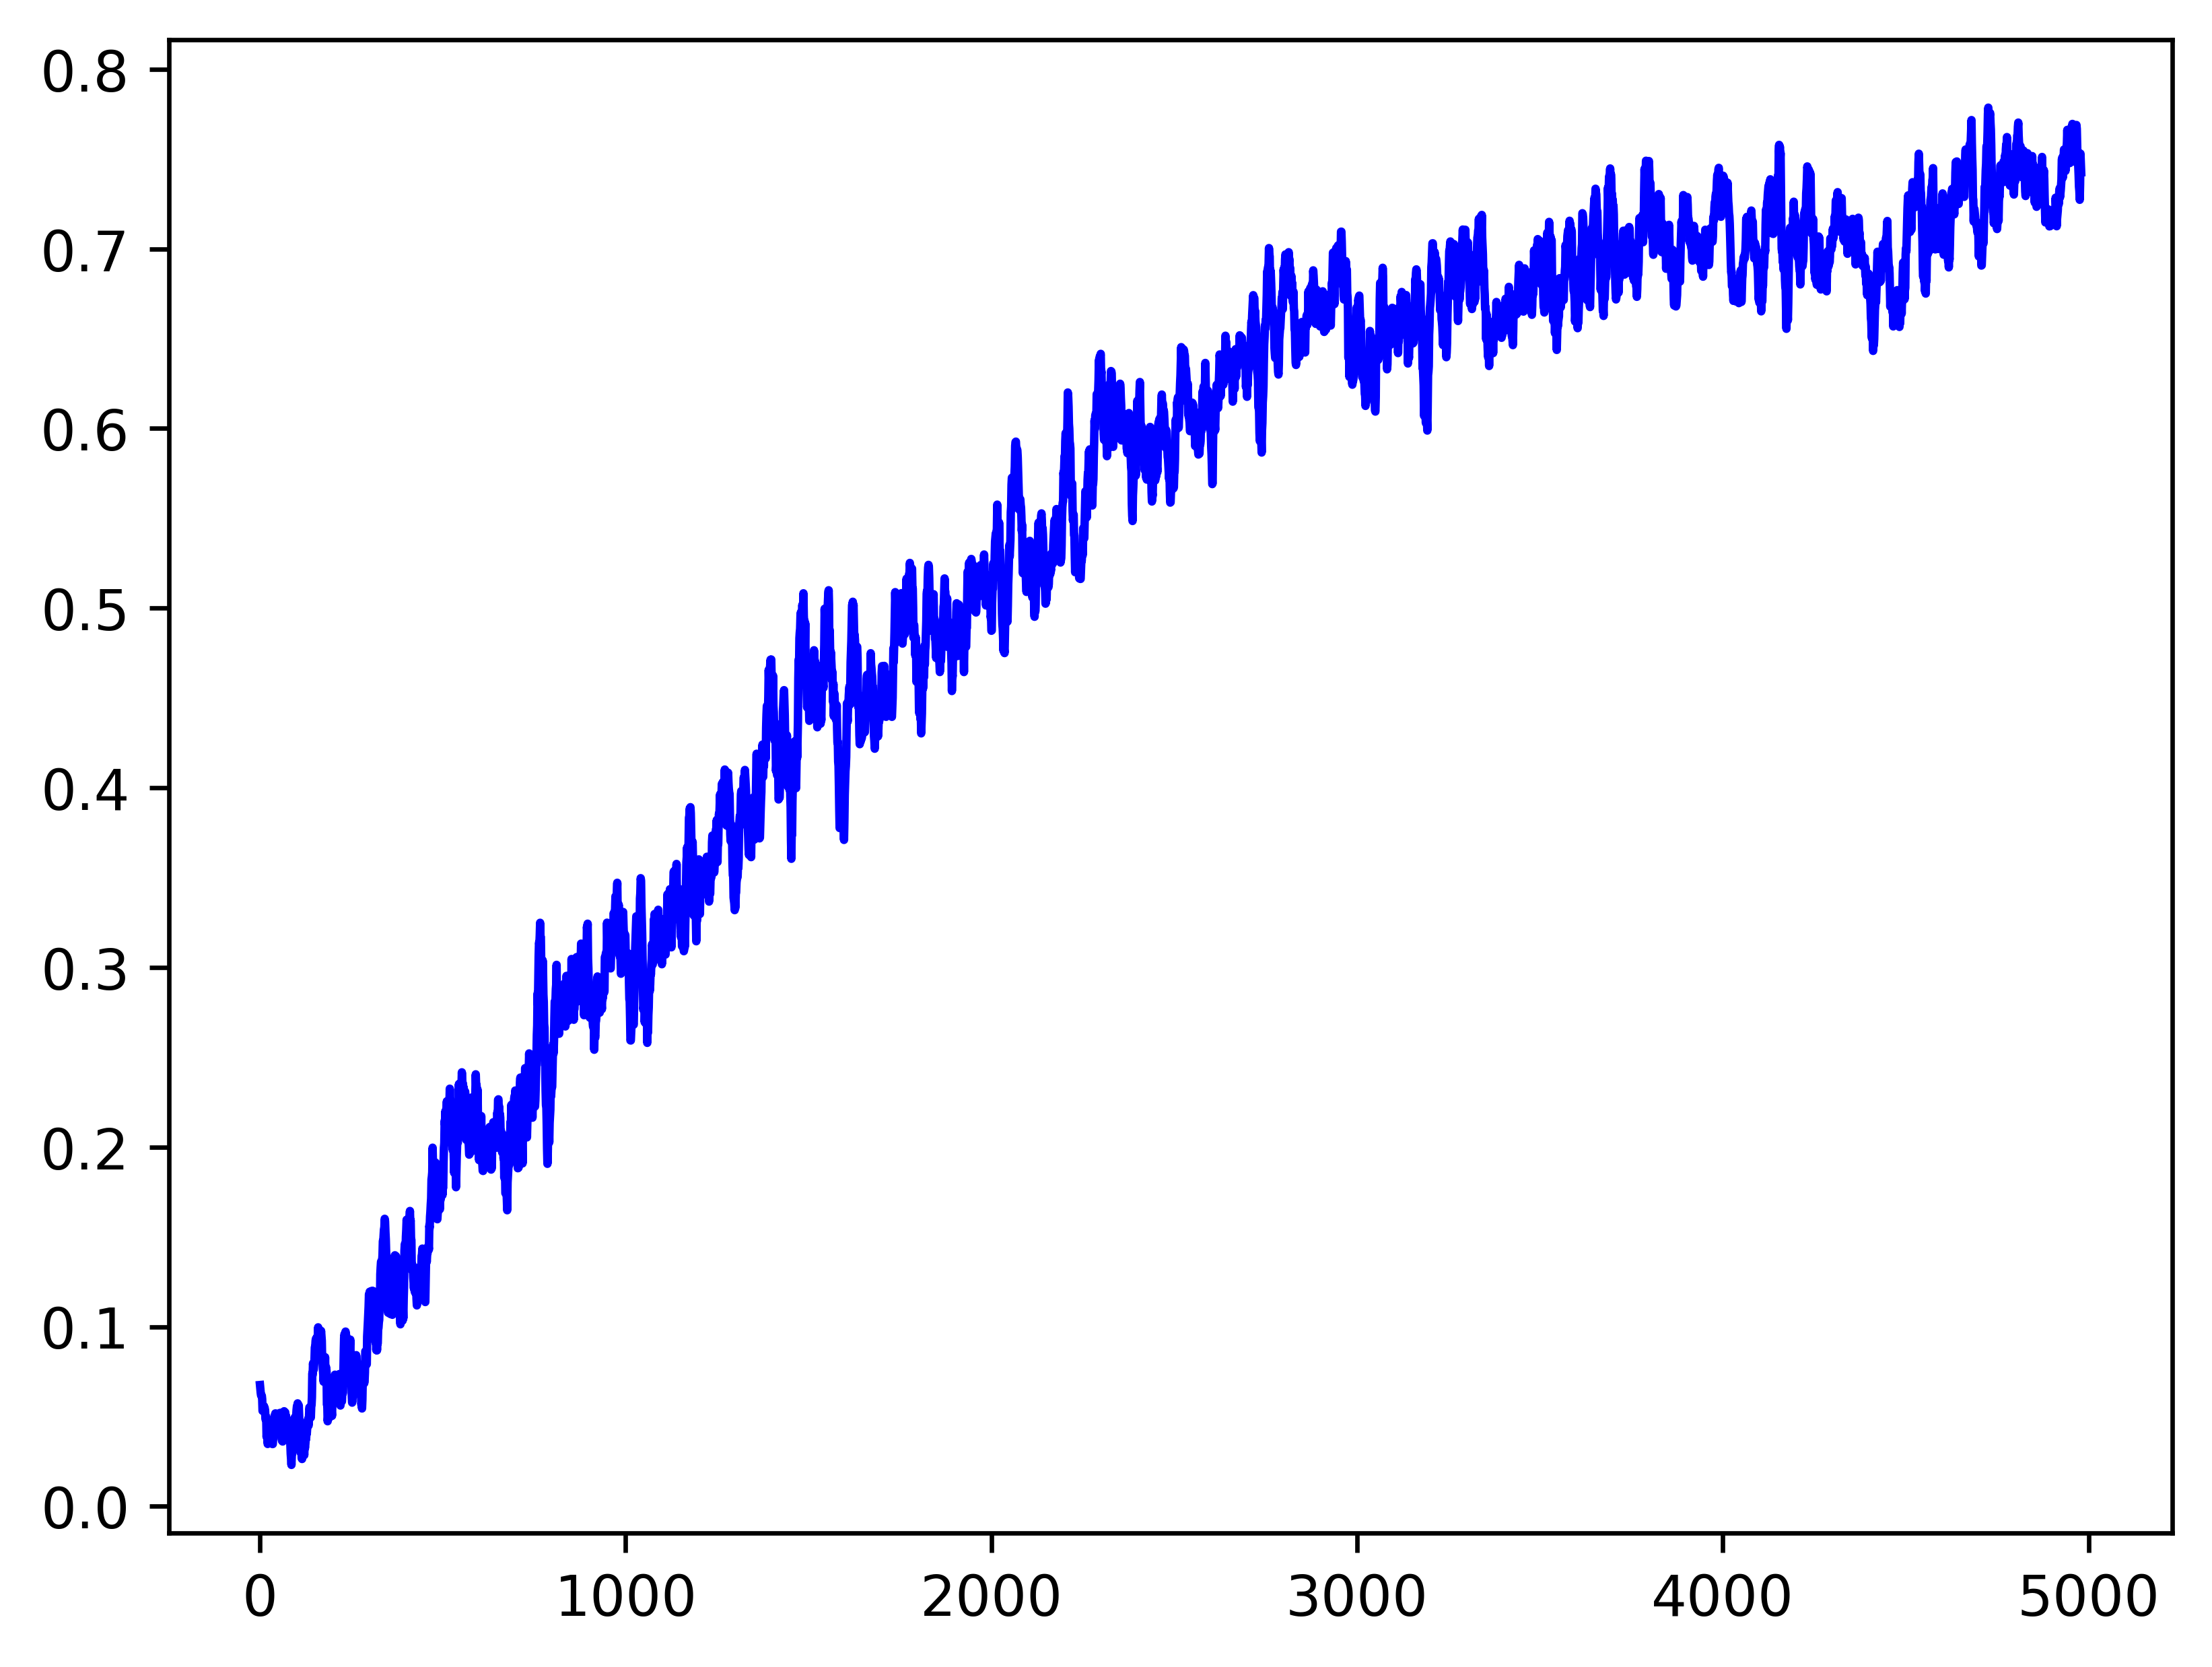

In [60]:
# Variables a guardar para reward plot
plt.plot(data_trureward_mavecr, label="DAC-ML", color='blue')

plt.fill_between(np.linspace(0, length-1, length), min_val, max_val, color='blue', alpha=.2)

# Rewards - all

In [61]:
#models = ['SEC_500', 'SEC_1000', 'MFEC_VAE_25K', 'MFEC_RP_25K', 'MFEC_VAE_100K', 'MFEC_RP_100K', 'DQN_5k', 'DQN_25k', 'ERLAM_5k', 'ERLAM_25k']
#models = ['noGi_500', 'NSEC_500', 'NSEC_1000', 'SEC_500', 'SEC_1000', 'MFEC_VAE_25K', 'MFEC_RP_25K', 'MFEC_VAE_100K', 'MFEC_RP_100K', 'DQN_5k', 'DQN_25k', 'ERLAM_5k', 'ERLAM_25k']
#models = ['NSEC_500', 'SEC_500', 'SEC_1000', 'MFEC_VAE_25K', 'MFEC_RP_25K', 'MFEC_VAE_100K', 'MFEC_RP_100K', 'DQN_5k', 'DQN_25k', 'ERLAM_5k', 'ERLAM_25k']
#models = ['noGi_500', 'NSEC_500', 'SEC_500', 'SEC_1000', 'MFEC_VAE_25K', 'MFEC_RP_25K', 'MFEC_VAE_100K', 'MFEC_RP_100K', 'ERLAM_5k', 'ERLAM_25k', 'DQN_5k', 'DQN_25k']
#models = ['DQN_ae100_cylinder', 'DQN_sparse100_cylinder', 'DQN_ae1k_cylinder', 'DQN_sparse1k_cylinder', 'MFEC_ae100_cylinder', 'MFEC_sparse100_cylinder', 'SEC_ae100_cylinder', 'SEC_sparse100_cylinder']
#models = ['DQN_ae100_cylinder', 'DQN_sparse100_cylinder', 'MFEC_ae100_cylinder', 'MFEC_sparse100_cylinder', 'SEC_ae100_cylinder', 'SEC_sparse100_cylinder']
#models = ['noGi_500', 'NSEC_500', 'NSEC_1000', 'SEC_500', 'SEC_1000', 'MFEC_VAE_25K', 'MFEC_RP_25K', 'MFEC_VAE_100K', 'MFEC_RP_100K', 'ERLAM_5k', 'ERLAM_25k', 'DQN_5k', 'DQN_25k']
models = ['DQN_ae100_'+task, 'DQN_sparse100_'+task, 'MFEC_ae100_'+task, 'MFEC_sparse100_'+task, 'SEC_ae100_'+task, 'SEC_sparse100_'+task]
models = ['DQN_ae1k_'+task, 'DQN_sparse1k_'+task]
ltm = 500

In [62]:
reward_data = {}
#ltm_data = {}
window_width = 20


for model in models:

    data_trureward = data[model]['abs_tru_reward']
    data_trureward = np.asarray(data_trureward, dtype=np.float32)
    print("data_truerward_sum ", np.sum(data_trureward))

    if np.sum(data_trureward) > 0:
        if len(data_trureward[0]) > 5000: 
            data_half = np.hsplit(data_trureward, 2)
            data_trureward = data_half[0]

        mean = np.mean(data_trureward, axis=0)
        yerr = np.std(data_trureward, axis=0) / math.sqrt(len(data_trureward))

        data_trureward_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
        data_trureward_mavecr = (data_trureward_cumsum[window_width:] - data_trureward_cumsum[:-window_width]) / window_width

        data_trureward_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
        data_trureward_mavecr_std = (data_trureward_cumsum_std[window_width:] - data_trureward_cumsum_std[:-window_width]) / window_width

        data_totalreward = np.sum(data_trureward, axis=1) 
        #data_totalreward_mean = np.mean(data_totalreward)
        #data_totalreward_std = np.std(data_totalreward)

        reward = {}
        reward['total'] = data_totalreward
        reward['mean'] = np.mean(mean)
        reward['mavecr'] = data_trureward_mavecr
        reward['mavecr_std'] = data_trureward_mavecr_std
        reward['min_val'] = data_trureward_mavecr - data_trureward_mavecr_std
        reward['max_val'] = data_trureward_mavecr + data_trureward_mavecr_std
        reward['length'] = data_trureward_mavecr_std.shape[0]

        reward_data[model] = reward

save_plot_data(reward_data, 'reward_1k_'+task, file_path)

data_truerward_sum  136210.1
data_truerward_sum  143328.69


In [36]:
reward_data = {}
ltm_data = {}
window_width = 20

ltm = 500

for model in models:

    data_trureward = data[model]['abs_tru_reward']
    data_trureward = np.asarray(data_trureward, dtype=np.float32)
    print("data_truerward_sum ", np.sum(data_trureward))

    data_ltm = data[model]['LTM_full']
    data_ltm = np.asarray(data_ltm, dtype=np.float32)
    data_ltm[data_ltm == 0] = ltm #correction: LTMs that were not filled completeley should get max value

    if np.sum(data_trureward) > 0:
        if len(data_trureward[0]) > 5000: 
            data_half = np.hsplit(data_trureward, 2)
            data_trureward = data_half[0]

        mean = np.mean(data_trureward, axis=0)
        yerr = np.std(data_trureward, axis=0) / math.sqrt(len(data_trureward))

        data_trureward_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
        data_trureward_mavecr = (data_trureward_cumsum[window_width:] - data_trureward_cumsum[:-window_width]) / window_width

        data_trureward_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
        data_trureward_mavecr_std = (data_trureward_cumsum_std[window_width:] - data_trureward_cumsum_std[:-window_width]) / window_width

        data_totalreward = np.sum(data_trureward, axis=1) 
        #data_totalreward_mean = np.mean(data_totalreward)
        #data_totalreward_std = np.std(data_totalreward)

        reward = {}
        reward['total'] = data_totalreward
        reward['mean'] = np.mean(mean)
        reward['mavecr'] = data_trureward_mavecr
        reward['mavecr_std'] = data_trureward_mavecr_std
        reward['min_val'] = data_trureward_mavecr - data_trureward_mavecr_std
        reward['max_val'] = data_trureward_mavecr + data_trureward_mavecr_std
        reward['length'] = data_trureward_mavecr_std.shape[0]

        reward_data[model] = reward

        lmean = np.mean(data_ltm)
        lerr = np.std(data_ltm) / math.sqrt(len(data_ltm))

        ltm_full = {}
        ltm_full['total'] = data_ltm
        ltm_full['mean'] = lmean
        ltm_full['error'] = lerr
        ltm_full['min_val'] = lmean - lerr
        ltm_full['max_val'] = lmean + lerr

        ltm_data[model] = ltm_full

save_plot_data(reward_data, 'reward_new_'+task, file_path)
#save_plot_data(ltm_data, 'ltm_data', file_path)

data_truerward_sum  125662.44


KeyError: 'LTM_full'

In [34]:
# Variables a guardar para reward plot
d = reward_data['SEC']
l = ltm_data['SEC']

plt.axvline(x=l['mean'])
plt.axvspan(l['min_val'], l['max_val'], facecolor='g', alpha=0.25)

plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)

KeyError: 'SEC'

# Steps - single

In [20]:
# Variables a computar para reward plot
window_width = 20
data_steps = data['SEC']['real_steps_ts']
data_steps = np.asarray(data_steps, dtype=np.float32)

mean = np.mean(data_steps, axis=0)
yerr = np.std(data_steps, axis=0) / math.sqrt(len(data_steps))

data_steps_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
data_steps_mavecr = (data_steps_cumsum[window_width:] - data_steps_cumsum[:-window_width]) / window_width

data_steps_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
data_steps_mavecr_std = (data_steps_cumsum_std[window_width:] - data_steps_cumsum_std[:-window_width]) / window_width

min_val = data_steps_mavecr - data_steps_mavecr_std
max_val = data_steps_mavecr + data_steps_mavecr_std
length = data_steps_mavecr_std.shape[0]

KeyError: 'SEC'

In [21]:
# Variables a guardar para reward plot
plt.plot(data_steps_mavecr, label="Reactive", color='blue')
plt.fill_between(np.linspace(0, length-1, length), min_val, max_val, color='blue', alpha=.2)

NameError: name 'data_steps_mavecr' is not defined

# Steps - all

In [18]:
steps_data = {}
window_width = 20

for model in models:
    #steps_data["cl"+str(clr)+"_stm"+str(stm)+"_ep1000_dac"] = get_condition_dac("C"+str(clr), "STM"+str(stm), "EP1000", "dac")

    #data_trusteps = cl4_stm50_ep1000_dac['abs_tru_steps']
    data_trusteps = data[model]['real_steps_ts']
    data_trusteps = np.asarray(data_trusteps, dtype=np.float32)
    print("data_trusteps_sum ", np.sum(data_trusteps))
    if np.sum(data_trusteps) > 0:
        if len(data_trusteps[0]) > 5000: 
            data_half = np.hsplit(data_trusteps, 2)
            data_trusteps = data_half[0]

        mean = np.mean(data_trusteps, axis=0)
        yerr = np.std(data_trusteps, axis=0) / math.sqrt(len(data_trusteps))

        data_trusteps_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
        data_trusteps_mavecr = (data_trusteps_cumsum[window_width:] - data_trusteps_cumsum[:-window_width]) / window_width

        data_trusteps_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
        data_trusteps_mavecr_std = (data_trusteps_cumsum_std[window_width:] - data_trusteps_cumsum_std[:-window_width]) / window_width

        steps = {}
        steps['mavecr'] = data_trusteps_mavecr
        steps['mavecr_std'] = data_trusteps_mavecr_std
        steps['min_val'] = data_trusteps_mavecr - data_trusteps_mavecr_std
        steps['max_val'] = data_trusteps_mavecr + data_trusteps_mavecr_std
        steps['length'] = data_trusteps_mavecr_std.shape[0]

        steps_data[model] = steps

save_plot_data(steps_data, 'steps_new', file_path)

data_trusteps_sum  0.0
data_trusteps_sum  0.0
data_trusteps_sum  5048037.0
data_trusteps_sum  5056359.0
data_trusteps_sum  9147978.0
data_trusteps_sum  6654452.0
data_trusteps_sum  0.0
data_trusteps_sum  0.0


KeyError: 'real_steps_ts'

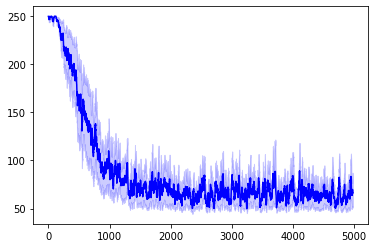

In [16]:
# Variables a guardar para reward plot
d = steps_data['SEC']

plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)

# Steps normalized - all

In [17]:
stepsnorm_data = {}
window_width = 20
clr = 4
models = ['SEC', 'NSEC', 'MFEC']
for model in models:

    data_trusteps = data[model]['real_steps_ts']
    data_trusteps = np.asarray(data_trusteps, dtype=np.float32)
    data_trusteps = data_trusteps * clr   
    print("data_trusteps_sum ", np.sum(data_trusteps))
    if np.sum(data_trusteps) > 0:   
        if len(data_trusteps[0]) > 5000: 
            data_half = np.hsplit(data_trusteps, 2)
            data_trusteps = data_half[0]

        mean = np.mean(data_trusteps, axis=0)
        yerr = np.std(data_trusteps, axis=0) / math.sqrt(len(data_trusteps))

        data_trusteps_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
        data_trusteps_mavecr = (data_trusteps_cumsum[window_width:] - data_trusteps_cumsum[:-window_width]) / window_width

        data_trusteps_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
        data_trusteps_mavecr_std = (data_trusteps_cumsum_std[window_width:] - data_trusteps_cumsum_std[:-window_width]) / window_width

        steps = {}
        steps['mavecr'] = data_trusteps_mavecr
        steps['mavecr_std'] = data_trusteps_mavecr_std
        steps['min_val'] = data_trusteps_mavecr - data_trusteps_mavecr_std
        steps['max_val'] = data_trusteps_mavecr + data_trusteps_mavecr_std
        steps['length'] = data_trusteps_mavecr_std.shape[0]

        stepsnorm_data[model] = steps

save_plot_data(stepsnorm_data, 'stepsnorm', file_path)

data_trusteps_sum  5333344.0
data_trusteps_sum  9993868.0
data_trusteps_sum  9929764.0


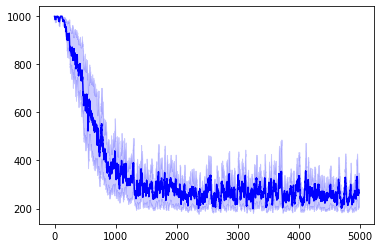

In [18]:
# Variables a guardar para reward plot
d = stepsnorm_data['SEC']

plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)

# Steps accumulated - single

In [77]:
# Variables a computar para reward plot
window_width = 20
data_steps_acc = data['SEC']['acc_steps_ts']
data_steps_acc = np.asarray(data_steps_acc, dtype=np.float32)

mean = np.mean(data_steps_acc, axis=0)
yerr = np.std(data_steps_acc, axis=0) / math.sqrt(len(data_steps_acc))

data_steps_acc_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
data_steps_acc_mavecr = (data_steps_acc_cumsum[window_width:] - data_steps_acc_cumsum[:-window_width]) / window_width

data_steps_acc_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
data_steps_acc_mavecr_std = (data_steps_acc_cumsum_std[window_width:] - data_steps_acc_cumsum_std[:-window_width]) / window_width

min_val = data_steps_acc_mavecr - data_steps_acc_mavecr_std
max_val = data_steps_acc_mavecr + data_steps_acc_mavecr_std
length = data_steps_acc_mavecr_std.shape[0]


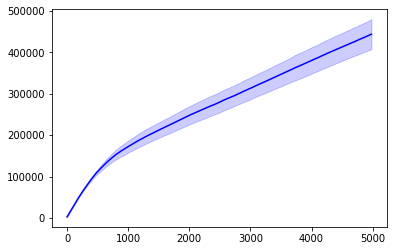

In [78]:
# Variables a guardar para reward plot
plt.plot(data_steps_acc_mavecr, label="Reactive", color='blue')
plt.fill_between(np.linspace(0, length-1, length), min_val, max_val, color='blue', alpha=.2)

# Steps accumulated - all

In [19]:
stepsacc_data = {}
window_width = 20

for model in models:

    data_accsteps = data[model]['acc_steps_ts']
    data_accsteps = np.asarray(data_accsteps, dtype=np.float32)
    print("data_accsteps_sum ", np.sum(data_accsteps))

    if np.sum(data_accsteps) > 0:
        if len(data_accsteps[0]) > 5000: 
            data_half = np.hsplit(data_accsteps, 2)
            data_accsteps = data_half[0]

        mean = np.mean(data_accsteps, axis=0)
        yerr = np.std(data_accsteps, axis=0) / math.sqrt(len(data_accsteps))

        data_accsteps_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
        data_accsteps_mavecr = (data_accsteps_cumsum[window_width:] - data_accsteps_cumsum[:-window_width]) / window_width

        data_accsteps_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
        data_accsteps_mavecr_std = (data_accsteps_cumsum_std[window_width:] - data_accsteps_cumsum_std[:-window_width]) / window_width

        totalsteps = []
        for d in data_accsteps: 
            #print(d[-1])
            totalsteps.append(d[-1])

        steps = {}
        steps['total'] = totalsteps
        steps['mavecr'] = data_accsteps_mavecr
        steps['mavecr_std'] = data_accsteps_mavecr_std
        steps['min_val'] = data_accsteps_mavecr - data_accsteps_mavecr_std
        steps['max_val'] = data_accsteps_mavecr + data_accsteps_mavecr_std
        steps['length'] = data_accsteps_mavecr_std.shape[0]

        stepsacc_data[model] = steps

save_plot_data(stepsacc_data, 'stepsacc', file_path)

data_accsteps_sum  0.0
data_accsteps_sum  0.0
data_accsteps_sum  17164959000.0
data_accsteps_sum  17238500000.0
data_accsteps_sum  27229293000.0
data_accsteps_sum  21056660000.0
data_accsteps_sum  0.0
data_accsteps_sum  0.0
data_accsteps_sum  1238325900.0
data_accsteps_sum  1342253400.0
data_accsteps_sum  1563125000.0
data_accsteps_sum  1239034200.0


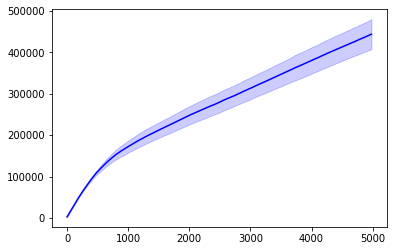

In [94]:
# Variables a guardar para reward plot
d = stepsacc_data['SEC']
plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)

# Entropy - single

In [47]:
# Variables a computar para reward plot
window_width = 20
data_truentropy = data['MFEC-ae']['mean_entropy']
data_truentropy = np.asarray(data_truentropy, dtype=np.float32)

mean = np.mean(data_truentropy, axis=0)
yerr = np.std(data_truentropy, axis=0) / math.sqrt(len(data_truentropy))

data_truentropy_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
data_truentropy_mavecr = (data_truentropy_cumsum[window_width:] - data_truentropy_cumsum[:-window_width]) / window_width

data_truentropy_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
data_truentropy_mavecr_std = (data_truentropy_cumsum_std[window_width:] - data_truentropy_cumsum_std[:-window_width]) / window_width

min_val = data_truentropy_mavecr - data_truentropy_mavecr_std
max_val = data_truentropy_mavecr + data_truentropy_mavecr_std
length = data_truentropy_mavecr_std.shape[0]

KeyError: 'MFEC-ae'

In [37]:
data_truentropy = data['MFEC-ae']['mean_entropy']
data_truentropy[0]

[-285.2932501298082,
 -812.6933965757439,
 -814.9255282240929,
 -816.6321589588728,
 -816.297160746203,
 -816.6749167279928,
 -816.7314912985609,
 -816.8391747333357,
 -816.0541964762481,
 -816.954287282699,
 -816.9354381264017,
 -816.7896725900581,
 -817.1094678618612,
 -817.0386460592739,
 -816.9087346238582,
 -816.7106620804933,
 -817.147032970199,
 -816.8621889509412,
 -816.7834307353226,
 -816.9210475358609,
 -816.9642193110687,
 -817.1411971619985,
 -816.8161380643575,
 -817.0075100931681,
 -817.0135655992513,
 -817.2177227543066,
 -818.0712588449944,
 -821.9200353213856,
 -821.1871120715797,
 -817.5743802669366,
 -817.6648516540283,
 -817.6183175236088,
 -819.2840268268387,
 -817.3819662302539,
 -816.9861586587489,
 -818.3583434406298,
 -819.4216756521802,
 -817.7781479391523,
 -823.2223853219824,
 -818.6836663853726,
 -828.9992879137014,
 -818.4255188820572,
 -817.7817731644535,
 -825.8355483114906,
 -821.4228182235397,
 -817.52477330458,
 -819.3448867975242,
 -818.022150354241

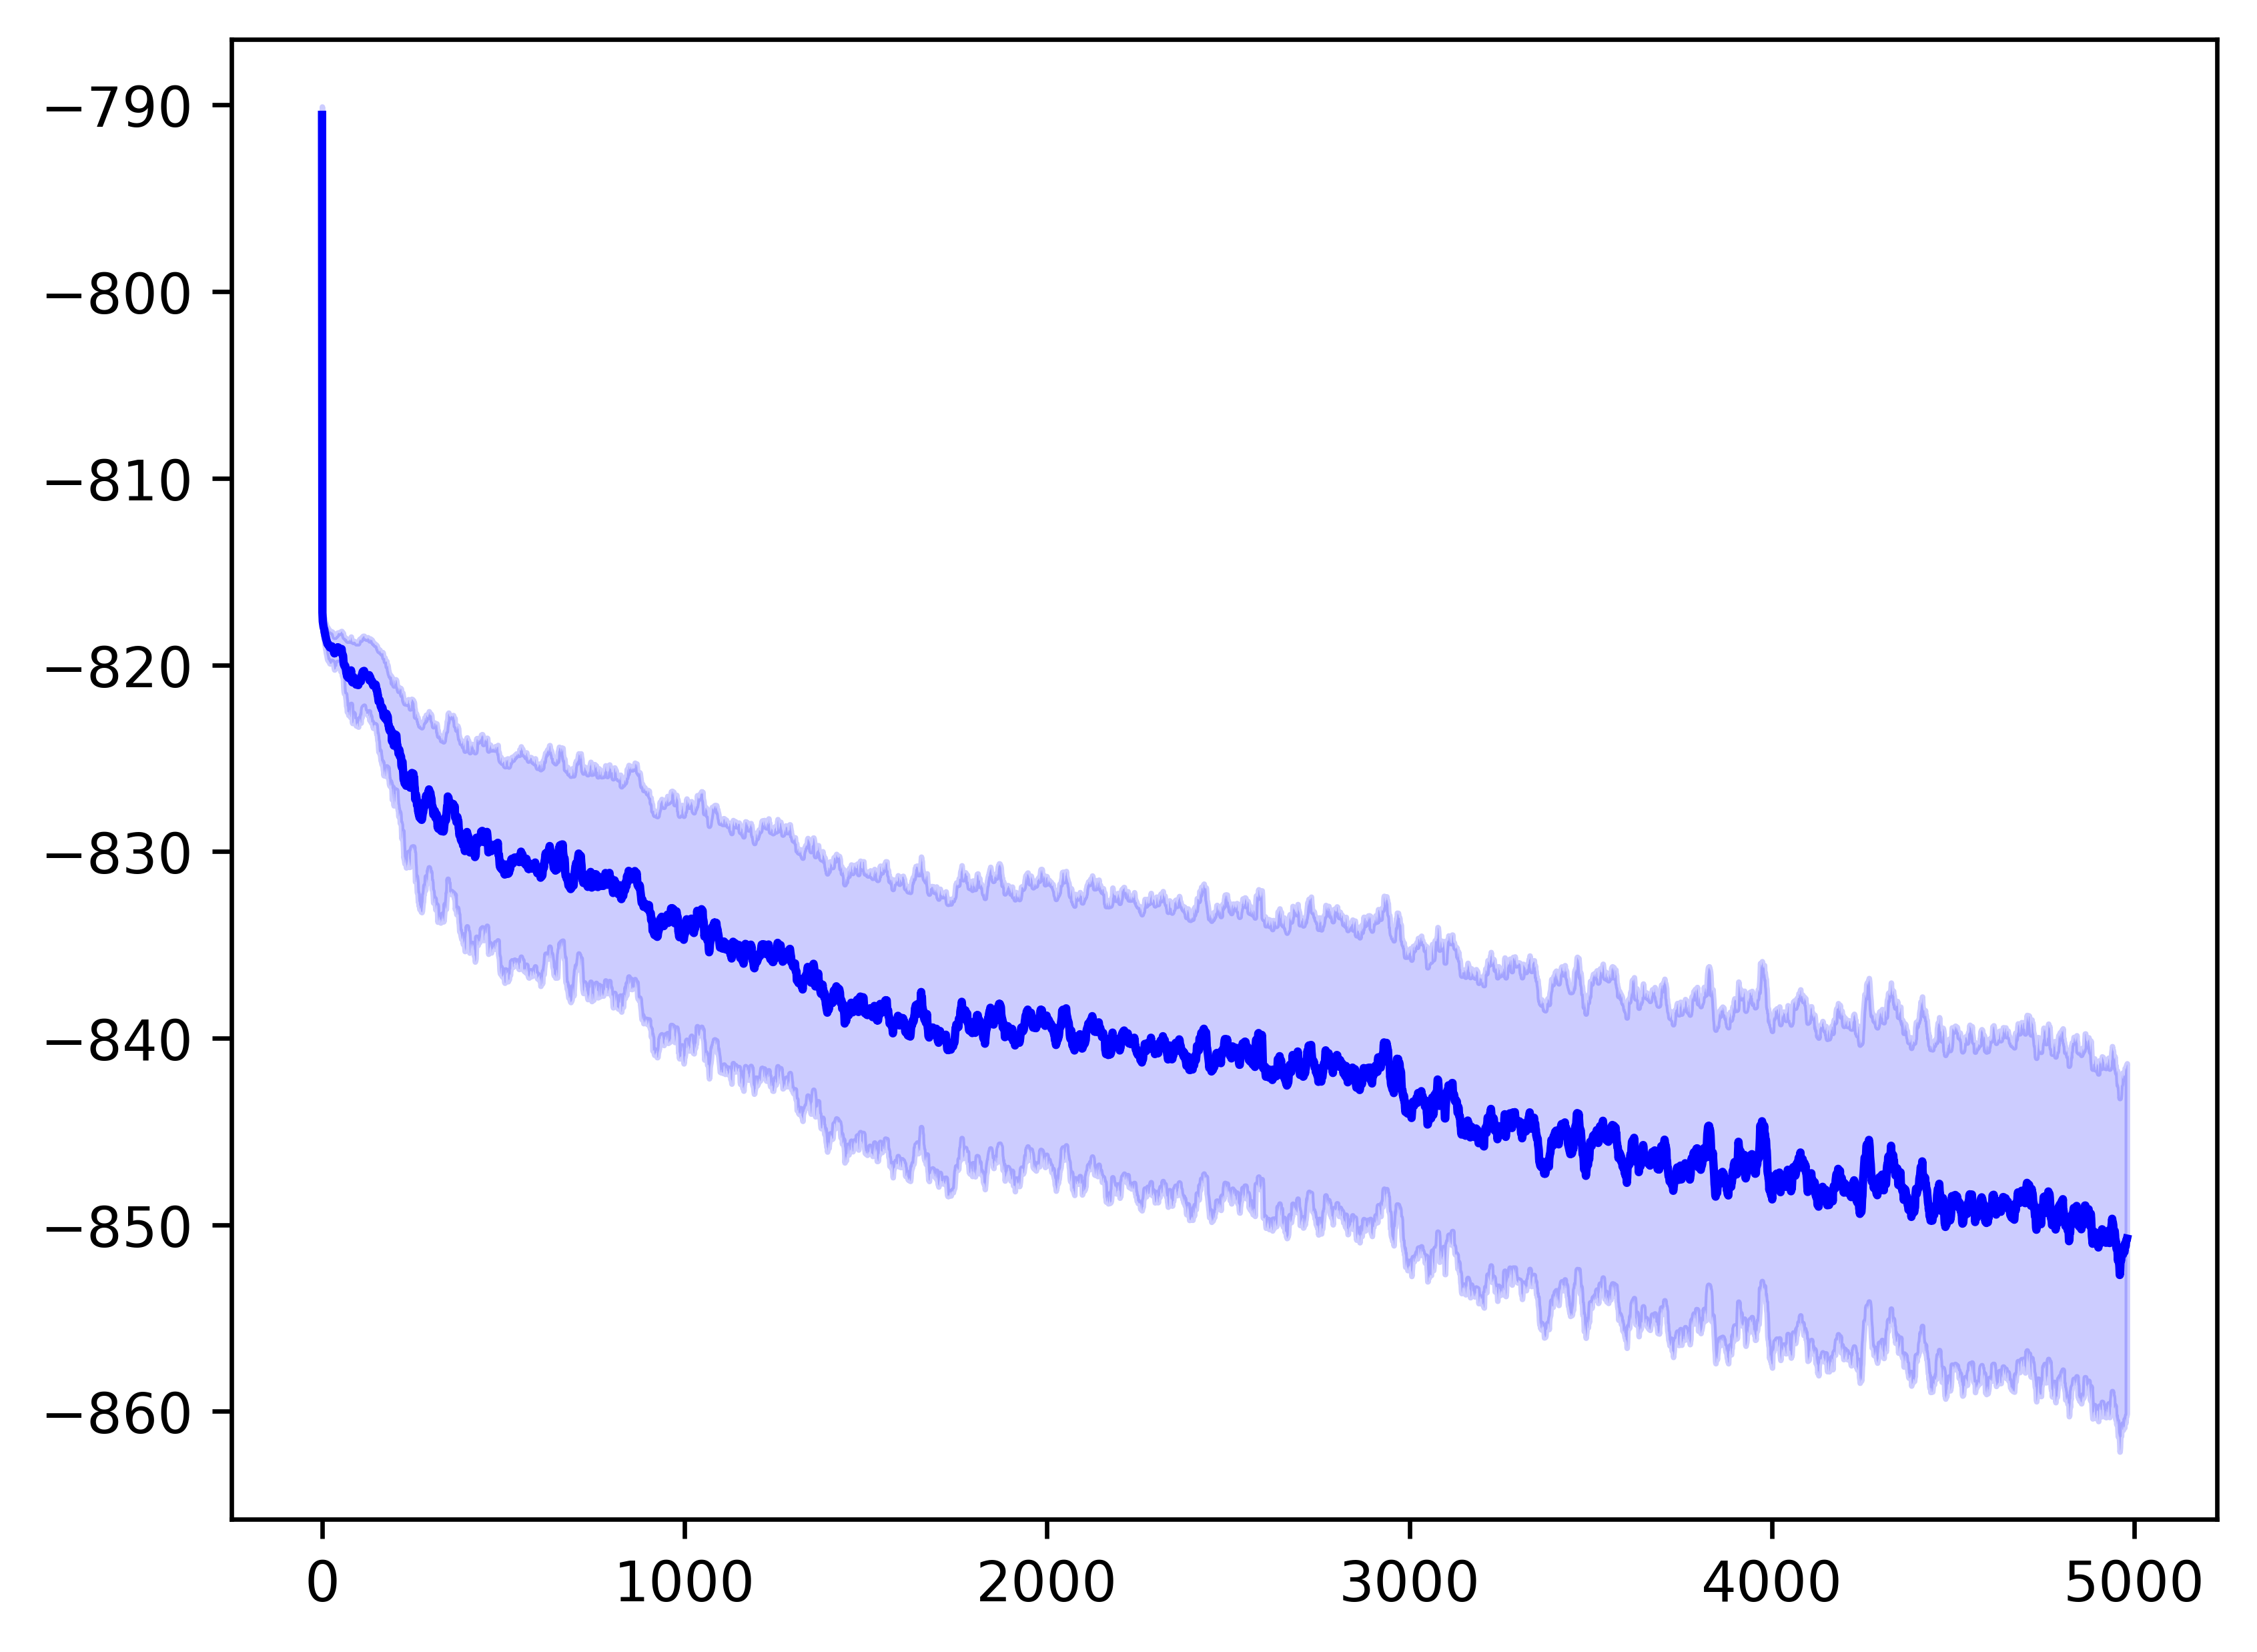

In [38]:
# Variables a guardar para reward plot
plt.plot(data_truentropy_mavecr, label="Reactive", color='blue')
plt.fill_between(np.linspace(0, length-1, length), min_val, max_val, color='blue', alpha=.2)

# Entropy - all

In [60]:
entropy_data = {}
window_width = 20

for model in models:
    #entropy_data["cl"+str(clr)+"_stm"+str(stm)+"_ep1000_dac"] = get_condition_dac("C"+str(clr), "STM"+str(stm), "EP1000", "dac")

    #data_truentropy = cl4_stm50_ep1000_dac['abs_tru_entropy']
    data_truentropy = data[model]['mean_entropy']
    data_truentropy = np.asarray(data_truentropy, dtype=np.float32)
    print("data_truentropy_sum ", np.sum(data_truentropy))
    #if np.sum(data_truentropy) > 0:                       
    if len(data_truentropy[0]) > 5000: 
        data_half = np.hsplit(data_truentropy, 2)
        data_truentropy = data_half[0]

    mean = np.mean(data_truentropy, axis=0)
    yerr = np.std(data_truentropy, axis=0) / math.sqrt(len(data_truentropy))

    data_truentropy_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
    data_truentropy_mavecr = (data_truentropy_cumsum[window_width:] - data_truentropy_cumsum[:-window_width]) / window_width

    data_truentropy_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
    data_truentropy_mavecr_std = (data_truentropy_cumsum_std[window_width:] - data_truentropy_cumsum_std[:-window_width]) / window_width

    entropy = {}
    entropy['mavecr'] = data_truentropy_mavecr
    entropy['mavecr_std'] = data_truentropy_mavecr_std
    entropy['min_val'] = data_truentropy_mavecr - data_truentropy_mavecr_std
    entropy['max_val'] = data_truentropy_mavecr + data_truentropy_mavecr_std
    entropy['length'] = data_truentropy_mavecr_std.shape[0]

    entropy_data[model] = entropy

save_plot_data(entropy_data, 'entropy_'+task, file_path)

data_truentropy_sum  15713.387
data_truentropy_sum  15744.936
data_truentropy_sum  0.0


IndexError: index 0 is out of bounds for axis 0 with size 0

In [36]:
# Variables a guardar para entropy plot
d = entropy_data['NSEC']

plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)

KeyError: 'NSEC'

# Layer activity - single

In [110]:
# Variables a computar para reward plot
window_width = 20
data_contextact = data['SEC']['contextual_relact']
data_contextact = np.asarray(data_contextact, dtype=np.float32)

mean = np.mean(data_contextact, axis=0)
yerr = np.std(data_contextact, axis=0) / math.sqrt(len(data_contextact))

data_contextact_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
data_contextact_mavecr = (data_contextact_cumsum[window_width:] - data_contextact_cumsum[:-window_width]) / window_width

data_contextact_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
data_contextact_mavecr_std = (data_contextact_cumsum_std[window_width:] - data_contextact_cumsum_std[:-window_width]) / window_width

min_val = data_contextact_mavecr - data_contextact_mavecr_std
max_val = data_contextact_mavecr + data_contextact_mavecr_std
length = data_contextact_mavecr_std.shape[0]

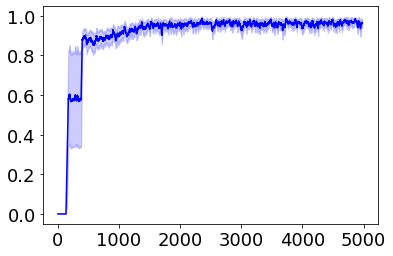

In [111]:
# Variables a guardar para reward plot
plt.plot(data_contextact_mavecr, label="Reactive", color='blue')
plt.fill_between(np.linspace(0, length-1, length), min_val, max_val, color='blue', alpha=.2)

# Layer activity - all

In [113]:
contextact_data = {}
window_width = 20


for model in models:

    data_contextact = data[model]['contextual_relact']
    data_contextact = np.asarray(data_contextact, dtype=np.float32)
    print("data_contextact_sum ", np.sum(data_contextact))
    if np.sum(data_contextact) > 0:                       
        if len(data_contextact[0]) > 5000: 
            data_half = np.hsplit(data_contextact, 2)
            data_contextact = data_half[0]

        mean = np.mean(data_contextact, axis=0)
        yerr = np.std(data_contextact, axis=0) / math.sqrt(len(data_contextact))

        data_contextact_cumsum = np.cumsum(np.insert(mean, 0, 0)) 
        data_contextact_mavecr = (data_contextact_cumsum[window_width:] - data_contextact_cumsum[:-window_width]) / window_width

        data_contextact_cumsum_std = np.cumsum(np.insert(yerr, 0, 0)) 
        data_contextact_mavecr_std = (data_contextact_cumsum_std[window_width:] - data_contextact_cumsum_std[:-window_width]) / window_width

        contextact = {}
        contextact['mavecr'] = data_contextact_mavecr
        contextact['mavecr_std'] = data_contextact_mavecr_std
        contextact['min_val'] = data_contextact_mavecr - data_contextact_mavecr_std
        contextact['max_val'] = data_contextact_mavecr + data_contextact_mavecr_std
        contextact['length'] = data_contextact_mavecr_std.shape[0]

        contextact_data[model] = contextact

save_plot_data(contextact_data, 'contextact', file_path)

data_contextact_sum  13475.424
data_contextact_sum  13332.277
data_contextact_sum  14287.819


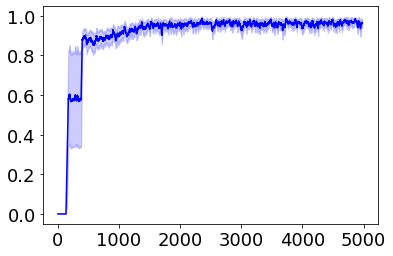

In [114]:
# Variables a guardar para entropy plot
d = contextact_data['SEC']

plt.plot(d['mavecr'], label="Reactive", color='blue')
plt.fill_between(np.linspace(0, d['length']-1, d['length']), d['min_val'], d['max_val'], color='blue', alpha=.2)